# 讀取訓練集

In [1]:
# 資料處理套件
import pandas as pd

# 讀取資料
df = pd.read_excel('curb_weight_bigdata.xlsx') 

# K-means

In [2]:
'''使機器自動辨別各資料間的關聯，再依可能較相關之資料群進行分群'''

# ML套件
from sklearn.cluster import KMeans

def kmeans_(df):
    
    included = ['Engine Size(L)', 'Cylinders']
    X = df[included]

    model = KMeans(n_clusters = 5, n_init='auto', random_state=1)  # 預計分為5群，迭代次數由模型自行定義
    model.fit(X)  # 建立模型

    df['Cluster'] = model.labels_  #將分類結果加回df
    
    return df

# 將訓練資料進行分群，增加可學習特徵，以提高預測準確度
df = kmeans_(df)

D:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# 模型訓練及驗證+學習曲線報告

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error  # 使用MAE替換原本的mean_squared_error
from sklearn.model_selection import learning_curve
import numpy as np
import pandas as pd
import statsmodels.api as sm

cv = KFold(n_splits=5, shuffle=True, random_state=42)

'''尋找最佳超參數'''
def find_best_hyper(X, y):
    # 定義XGBoost模型
    model = xgb.XGBRegressor()

    # 定義超參數範圍
    param_grid = {
        'colsample_bytree': [ 0.7, 0.8, 0.9],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [10, 11, 12],
        'n_estimators': [100, 125],
        'subsample': [0.8, 0.9]
    }
    # 使用Grid Search進行超參數調整
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=cv)  # 使用R2作為評估標準
    grid_search.fit(X, y)

    # 找到最佳超參數
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    return best_params


'''繪製學習曲線'''

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_learning_curve_r2(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#8737ED")  # 使用新的顏色碼
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#0091DA")  # 使用新的顏色碼
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#8737ED",  # 使用新的顏色碼
             label="Training R^2")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#0091DA",  # 使用新的顏色碼
             label="Cross-validation R^2")
    
    plt.legend(loc="best")
    return plt


'''訓練'''    

X = df[['Engine Size(L)', 'Cylinders', 'Cluster', 'weight']]
y = df['CO2 Emissions(g/km)']

best_params = find_best_hyper(X, y)
    
# 使用最佳超參數建立模型
best_model = xgb.XGBRegressor(**best_params)

# 使用最佳超參數對完整的資料進行訓練
best_model.fit(X, y)

# 計算預測值
y_pred = best_model.predict(X) 

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9}


Cross-Validation R^2 Scores: [0.8617114  0.86475797 0.87044111 0.87453344 0.85746284]
Mean of Cross-Validation R^2 Scores: 0.865781351658797


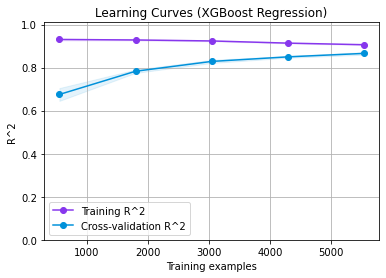

In [10]:
# 計算交叉驗證分數
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')  # 使用R^2作為評估標準

# 輸出交叉驗證分數
print("Cross-Validation R^2 Scores:", cv_scores)
print("Mean of Cross-Validation R^2 Scores:", np.mean(cv_scores))

# 繪製學習曲線
title_r2 = "Learning Curves (XGBoost Regression)"
plot_learning_curve_r2(best_model, title_r2, X, y, cv=cv, ylim=(0.0, 1.01), n_jobs=1)

plt.show()